In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nolearn.lasagne import visualize
%matplotlib inline

ERROR (theano.sandbox.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\theano\sandbox\gpuarray\__init__.py", line 95, in <module>
    init_dev(config.device)
  File "C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\theano\sandbox\gpuarray\__init__.py", line 46, in init_dev
    "Make sure Theano and libgpuarray/pygpu "
RuntimeError: ('Wrong major API version for gpuarray:', 1, 'Make sure Theano and libgpuarray/pygpu are in sync.')
C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

################################################################################
def plot_image(pixels, label, color="gray"):
    """
        Plot a image in 28x28pixels
    """
    pixels = pixels.reshape((28, 28))
    
    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap=color, interpolation=None)
    plt.show()
    
################################################################################
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_matrix(clf, X_test, y_test):
    plt.clf()
    cm = confusion_matrix(y_test,clf.predict(X_test))

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    #print(cm_normalized)
    plt.tick_params(labelsize=10)

    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm_normalized[i, j],2),horizontalalignment="center")    
    plt.colorbar()
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

### Split Data

In [3]:
X_train, labels = load_mnist('data/fashion', kind='train')
#X_test, y_test = load_mnist('/home/l34n/Downloads/fashion', kind='t10k')

### Plot an example - Without pre-processing

In [4]:
label = labels[0]
pixels = X_train[0]

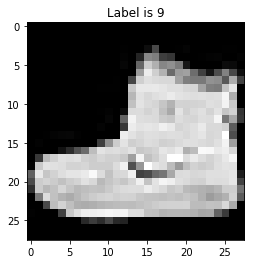

In [5]:
plot_image(pixels, label)

### Plot an example -  With pre-processing

In [6]:
from sklearn.preprocessing import Normalizer, MinMaxScaler

In [7]:
xs = MinMaxScaler([0, 1]).fit_transform(X_train)
#xs = Normalizer().fit_transform(X_train)

C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
label = labels[0]
pixels = xs[0]

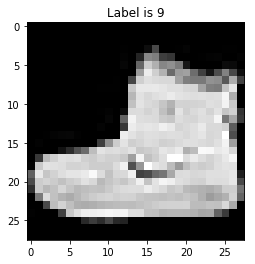

In [9]:
plot_image(pixels, label)

In [10]:
import lasagne

In [11]:
import theano
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer, FlattenLayer
from lasagne.nonlinearities import softmax

### Definición de RED

In [12]:
##Leandro's architecture
layers_5 = [
                (InputLayer, {'shape': (None, 1, 28, 28)}), #cantidad, canal(monocromatico),col,filas
                
                (Conv2DLayer, {'num_filters':32, 'filter_size': 5, 'W': lasagne.init.GlorotUniform(), 'nonlinearity': lasagne.nonlinearities.rectify}),
                (MaxPool2DLayer, {'pool_size': 2}), 
                 (Conv2DLayer, {'num_filters':64, 'filter_size': 5, 'W': lasagne.init.GlorotUniform(), 'nonlinearity': lasagne.nonlinearities.rectify}),
                (MaxPool2DLayer, {'pool_size': 2}), 
                (Conv2DLayer, {'num_filters':128, 'filter_size': 1, 'W': lasagne.init.GlorotUniform(), 'nonlinearity': lasagne.nonlinearities.rectify}),
                (MaxPool2DLayer, {'pool_size': 2}), 
                (FlattenLayer, {}),
    
                (DenseLayer, {'num_units': 1024, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p':0.5}),
    
                (DenseLayer, {'num_units': 510, 'nonlinearity': lasagne.nonlinearities.rectify}),
                (DropoutLayer, {'p':0.5}),
                    
                (DenseLayer, {'num_units': 10, 'nonlinearity': lasagne.nonlinearities.softmax}),
]

In [13]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.01, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [14]:
def create_network(npochs=5, batch_s=10000):
    return NeuralNet(
        layers=layers_5,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.01)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=False,
        batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.1, stop=0.01),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)

In [15]:
from sklearn.model_selection import train_test_split

net0 = create_network(100,2500) #npochs, batch_size

xs = xs.reshape(-1, 1, 28, 28)

X_train, X_test, y_train, y_test = train_test_split(xs, labels, random_state=42)

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

In [16]:
from timeit import default_timer as timer
comienzo = timer()


In [17]:
net0.fit(X_train, y_train)


# Neural Network with 1113588 learnable parameters

## Layer information

  #  name        size
---  ----------  --------
  0  input0      1x28x28
  1  conv2d1     32x24x24
  2  maxpool2d2  32x12x12
  3  conv2d3     64x8x8
  4  maxpool2d4  64x4x4
  5  conv2d5     128x4x4
  6  maxpool2d6  128x2x2
  7  flatten7    512
  8  dense8      1024
  9  dropout9    1024
 10  dense10     510
 11  dropout11   510
 12  dense12     10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     2.29774     2.27481    1.01008      0.40409  79.13s
      2     2.18251     1.54245    1.41496      0.44119  79.07s
      3     2.06230     1.60398    1.28574      0.42697  80.76s
      4     1.29013     0.81678    1.57953      0.68944  81.46s
      5     0.85951     0.64787    1.32668      0.74431  82.28s
      6     0.71322     0.56560    1.26101      0.77141  87.72s
      7     0.60921     0.53023    1.14894      0.79274  93.34s
  

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000000000B5C52B0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x000000000B9968D0>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 5, 'nonlinearity': <function rectify at 0x000000000B038278>, 'W': <lasagne.init.GlorotUniform object at 0x000000000BBFCBE0>, 'num_filters': 32}), (<class 'la...rs.dense.DenseLayer'>, {'num_units': 10, 'nonlinearity': <function softmax at 0x000000000B04DB38>})],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x000000000B5C6C18>,
     objective_loss_function=<function categorical_crossentropy at 0x000000000B306668>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x000000000BA50CF8>, <__main__.AdjustVariable objec

In [18]:
fin = timer() - comienzo
print("Tiempo red neuronal convulcionada:",fin, " sg ")

('Tiempo red neuronal convulcionada:', 7924.972965406509, ' sg ')


### Validación de Red

In [19]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

In [20]:
CLASSES = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

classes = [x for x in CLASSES.values()]

print(classification_report(y_test, net0.predict(X_test), target_names=classes))

             precision    recall  f1-score   support

T-shirt/top       0.86      0.84      0.85      1486
    Trouser       0.99      0.98      0.98      1546
   Pullover       0.83      0.87      0.85      1499
      Dress       0.90      0.91      0.91      1484
       Coat       0.85      0.84      0.84      1515
     Sandal       0.96      0.98      0.97      1493
      Shirt       0.76      0.74      0.75      1505
    Sneaker       0.96      0.93      0.95      1476
        Bag       0.96      0.97      0.96      1500
 Ankle boot       0.95      0.96      0.96      1496

avg / total       0.90      0.90      0.90     15000



Normalized confusion matrix


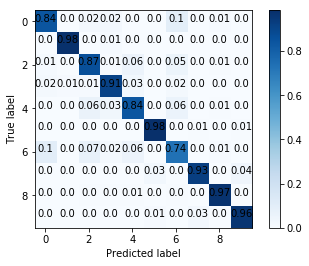

In [21]:
plot_matrix(net0, X_test, y_test)

<module 'matplotlib.pyplot' from 'C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

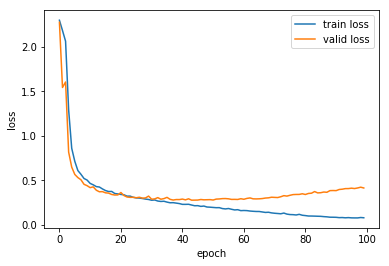

In [22]:
visualize.plot_loss(net0)

C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<module 'matplotlib.pyplot' from 'C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

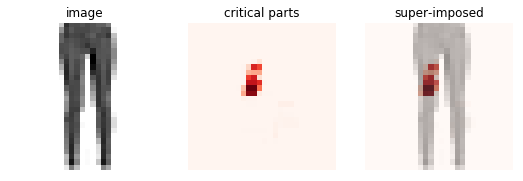

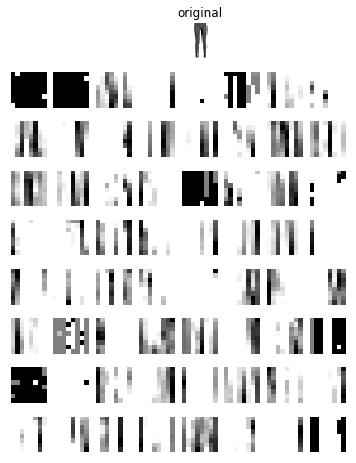

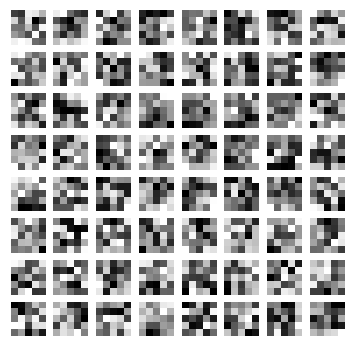

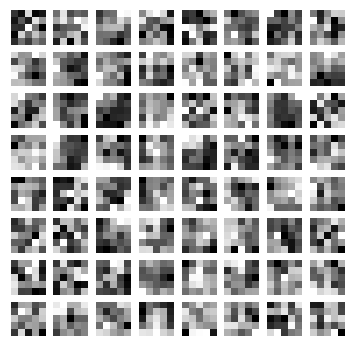

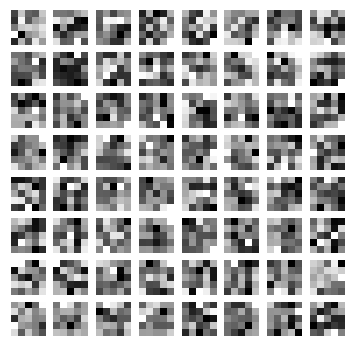

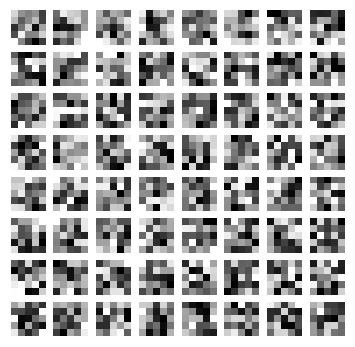

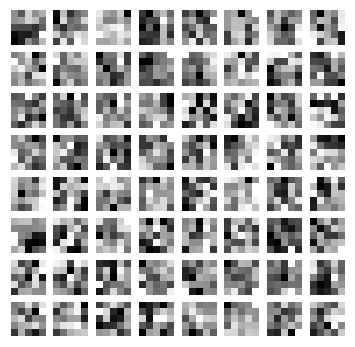

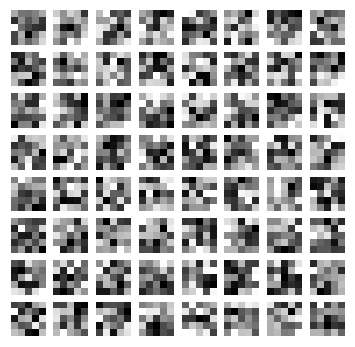

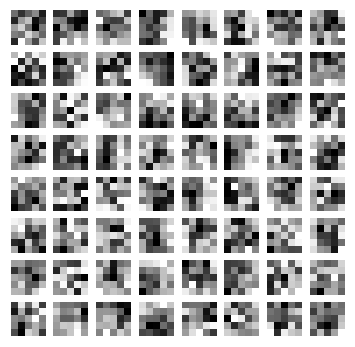

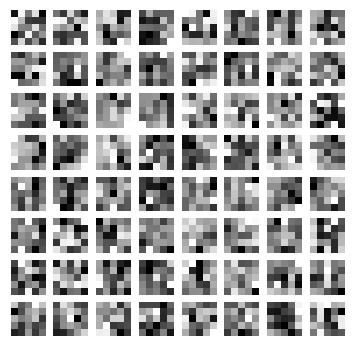

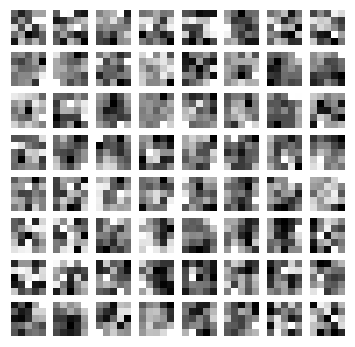

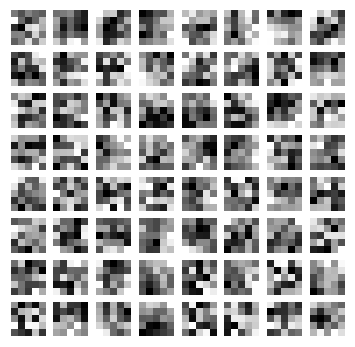

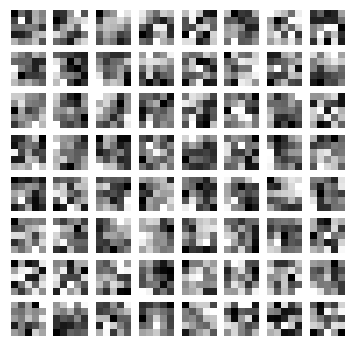

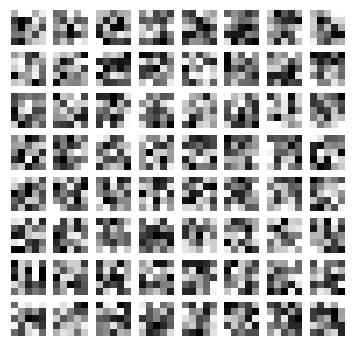

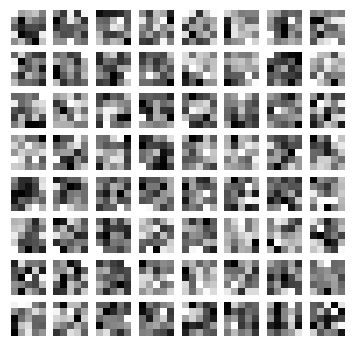

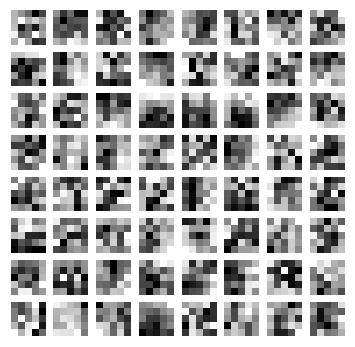

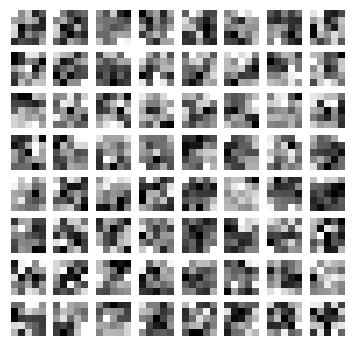

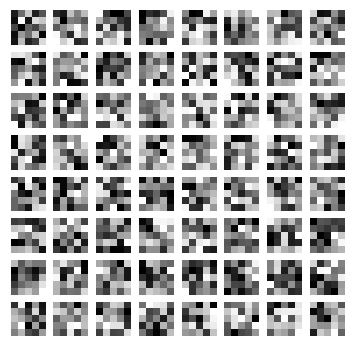

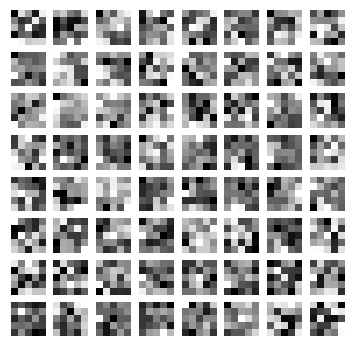

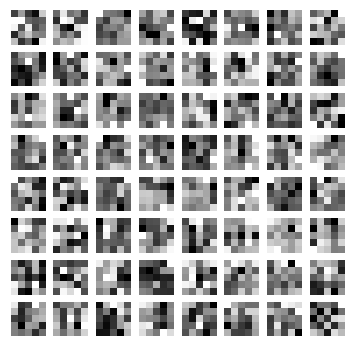

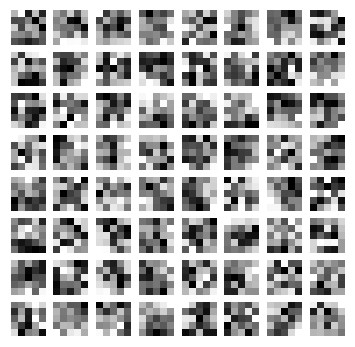

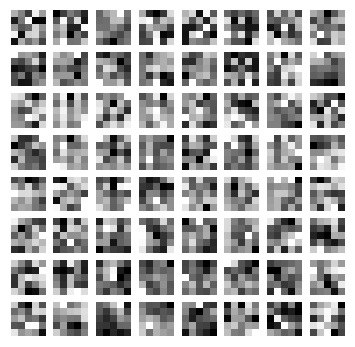

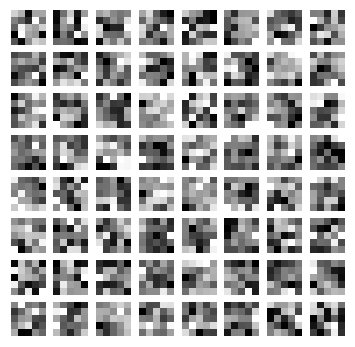

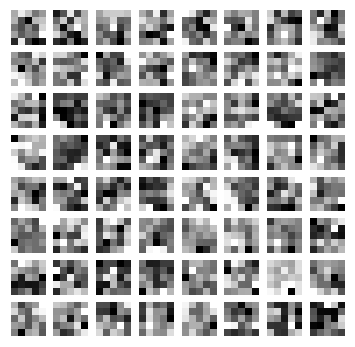

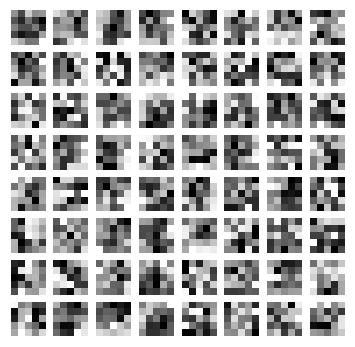

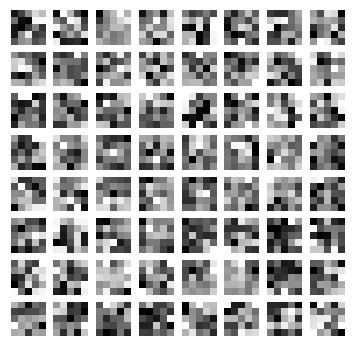

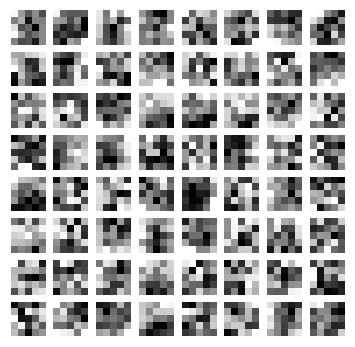

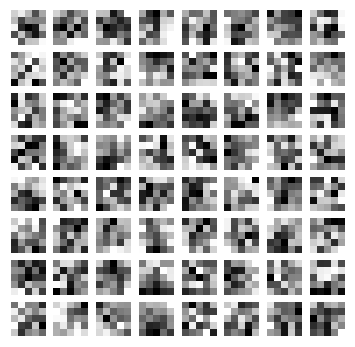

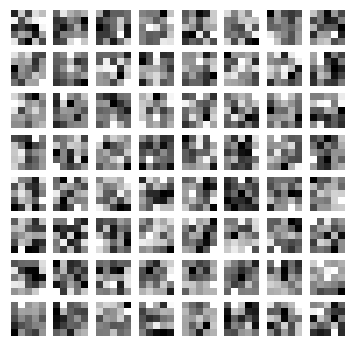

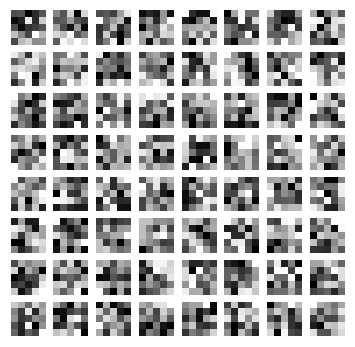

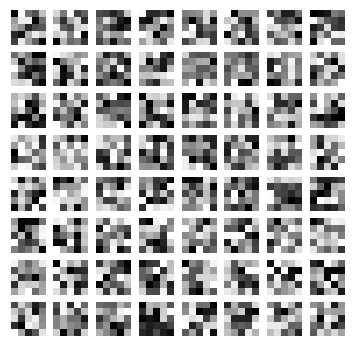

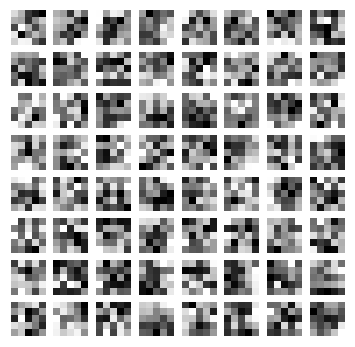

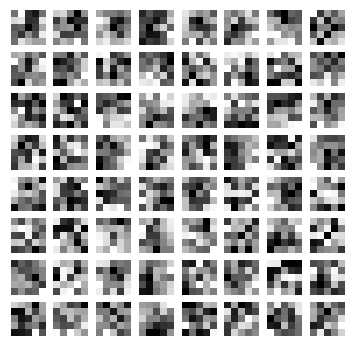

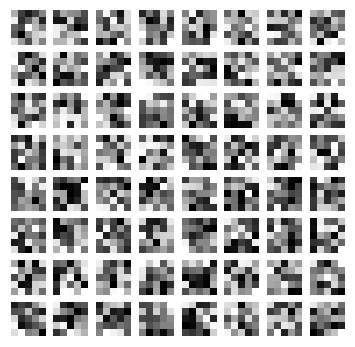

In [23]:
X = X_test[6].reshape(-1, 1, 28, 28)

visualize.plot_occlusion(net0, X, target=[1])
visualize.plot_conv_activity(net0.layers_['conv2d3'], X)
visualize.plot_conv_weights(layer=net0.layers_[3])

<module 'matplotlib.pyplot' from 'C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

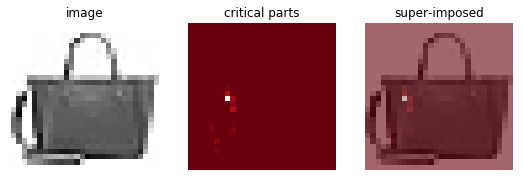

In [36]:
X = X_test[0].reshape(-1, 1, 28, 28)
visualize.plot_occlusion(net0, X, target=[0])


<module 'matplotlib.pyplot' from 'C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

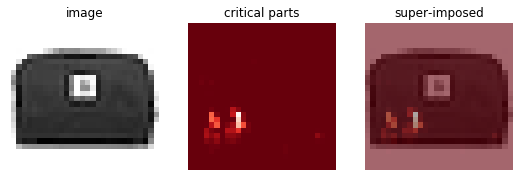

In [37]:
X = X_test[1].reshape(-1, 1, 28, 28)
visualize.plot_occlusion(net0, X, target=[0])

<module 'matplotlib.pyplot' from 'C:\Users\fdman\Anaconda3\envs\py27\lib\site-packages\matplotlib\pyplot.pyc'>

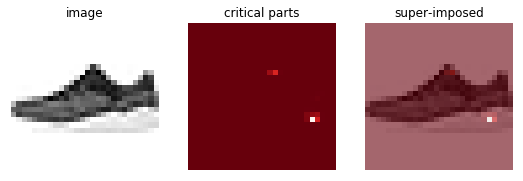

In [38]:
X = X_test[2].reshape(-1, 1, 28, 28)
visualize.plot_occlusion(net0, X, target=[0])

In [54]:
import sys
sys.getrecursionlimit()
sys.setrecursionlimit(2000)
#Ver picle produce error con valor por defecto.
import pickle 

with open('clasificadorNET-Damian1-score(0.9).pickle', 'wb') as f:
    pickle.dump(net0, f, -1)

#net2 = None with open('clasificadorNET-Damian1.pickle', 'rb') as f: net2 = pickle.load(f)

#print(y_test[0]) print (y_test[1]) print (y_test[2])

#net2.predict(x)